# Movement detection

In this script, we process the motion tracking and build a pipeline to automatically detect a movement event within a specific marker (e.g., wrist, head, ...)

These are then used to compare them with manual annotations and evaluate the performance of the algorithm.


## Folder settings

In [3]:
import os
import glob
import numpy as np
import pandas as pd

curfolder = os.getcwd()
print(curfolder)

# data are in curfolder/P0/P0/
datafolder = curfolder + '/TS_motiontracking'
print(datafolder)
folderstotrack = glob.glob(datafolder + '/mt_*')
# get rid of all 'centered'
folderstotrack = [x for x in folderstotrack if 'centered' not in x]
print(folderstotrack)

e:\FLESH_ContinuousBodilyEffort\TS_processing
e:\FLESH_ContinuousBodilyEffort\TS_processing/TS_motiontracking
['e:\\FLESH_ContinuousBodilyEffort\\TS_processing/TS_motiontracking\\mt_0_1_0_p0.csv', 'e:\\FLESH_ContinuousBodilyEffort\\TS_processing/TS_motiontracking\\mt_0_1_18_p0.csv', 'e:\\FLESH_ContinuousBodilyEffort\\TS_processing/TS_motiontracking\\mt_0_1_19_p0.csv', 'e:\\FLESH_ContinuousBodilyEffort\\TS_processing/TS_motiontracking\\mt_0_1_1_p0.csv', 'e:\\FLESH_ContinuousBodilyEffort\\TS_processing/TS_motiontracking\\mt_0_1_20_p0.csv', 'e:\\FLESH_ContinuousBodilyEffort\\TS_processing/TS_motiontracking\\mt_0_1_21_p0.csv', 'e:\\FLESH_ContinuousBodilyEffort\\TS_processing/TS_motiontracking\\mt_0_1_22_p0.csv', 'e:\\FLESH_ContinuousBodilyEffort\\TS_processing/TS_motiontracking\\mt_0_1_23_p0.csv', 'e:\\FLESH_ContinuousBodilyEffort\\TS_processing/TS_motiontracking\\mt_0_1_24_p0.csv', 'e:\\FLESH_ContinuousBodilyEffort\\TS_processing/TS_motiontracking\\mt_0_1_25_p0.csv', 'e:\\FLESH_Continuous

## Centering keypoints

With motion tracking, keypoints are moving as a consequence of other keypoints moving. For instance, I can jump from the ground and all the keypoints will move, despite only the knees being responsible for the movement per se.

To get to individual movements, we will center the keypoints in the following way:

1. head region
- head relative to Neck

2. torso region
- shoulders relative to hip midpoint

3. arm region
- elbow, wrist relative to shoulder midpoint

4. lower body region
- knee, ankle, heel relative to hip midpoint
- hip relative to ankle midpoint



In [48]:
import scipy.signal

for file in folderstotrack:

    print('working on' + file)  
    # load in the file
    df = pd.read_csv(file)
    
    # get rid of all columns with Toe, and Nose
    df = df.loc[:, ~df.columns.str.contains('Nose')]
    df = df.loc[:, ~df.columns.str.contains('Toe')]

    # get rid of all speed and vert_velocity columns
    df = df.loc[:, ~df.columns.str.contains('speed')]
    df = df.loc[:, ~df.columns.str.contains('vert_vel')]

    ##### HEAD
    # now we want all head coordinates center on Neck
    df['Head_x_c'] = df['Head_x'] - df['Neck_x']
    df['Head_y_c'] = df['Head_y'] - df['Neck_y']
    df['Head_z_c'] = df['Head_z'] - df['Neck_z']

    #### TORSO
    # now we need to create a new point 'HipMidpoint' in each dimension, which is in the middle of LHip and RHip
    # HipMid_y lies between LHip_y and RHip_y points for each time point
    df['HipMid_y'] = (df['LHip_y'] + df['RHip_y']) / 2
    df['HipMid_x'] = (df['LHip_x'] + df['RHip_x']) / 2
    df['HipMid_z'] = (df['LHip_z'] + df['RHip_z']) / 2

    # now we want to center shoulders on HipMid
    df['LShoulder_x_c'] = df['LShoulder_x'] - df['HipMid_x']
    df['LShoulder_y_c'] = df['LShoulder_y'] - df['HipMid_y']
    df['LShoulder_z_c'] = df['LShoulder_z'] - df['HipMid_z']
    df['RShoulder_x_c'] = df['RShoulder_x'] - df['HipMid_x']
    df['RShoulder_y_c'] = df['RShoulder_y'] - df['HipMid_y']
    df['RShoulder_z_c'] = df['RShoulder_z'] - df['HipMid_z']

    #### ARMS
    # now we want to center elbows and wrists on neck
    df['LElbow_x_c'] = df['LElbow_x'] - df['Neck_x']
    df['LElbow_y_c'] = df['LElbow_y'] - df['Neck_y']
    df['LElbow_z_c'] = df['LElbow_z'] - df['Neck_z']
    df['RElbow_x_c'] = df['RElbow_x'] - df['Neck_x']
    df['RElbow_y_c'] = df['RElbow_y'] - df['Neck_y']
    df['RElbow_z_c'] = df['RElbow_z'] - df['Neck_z']

    df['LWrist_x_c'] = df['LWrist_x'] - df['Neck_x']
    df['LWrist_y_c'] = df['LWrist_y'] - df['Neck_y']
    df['LWrist_z_c'] = df['LWrist_z'] - df['Neck_z']
    df['RWrist_x_c'] = df['RWrist_x'] - df['Neck_x']
    df['RWrist_y_c'] = df['RWrist_y'] - df['Neck_y']
    df['RWrist_z_c'] = df['RWrist_z'] - df['Neck_z']

    #### LOWER BODX
    # now we want to center knees, ankles and heel on HipMid
    df['LKnee_x_c'] = df['LKnee_x'] - df['HipMid_x']
    df['LKnee_y_c'] = df['LKnee_y'] - df['HipMid_y']
    df['LKnee_z_c'] = df['LKnee_z'] - df['HipMid_z']
    df['RKnee_x_c'] = df['RKnee_x'] - df['HipMid_x']
    df['RKnee_y_c'] = df['RKnee_y'] - df['HipMid_y']
    df['RKnee_z_c'] = df['RKnee_z'] - df['HipMid_z']

    # df['LAnkle_x_c'] = df['LAnkle_x'] - df['HipMid_x']
    # df['LAnkle_y_c'] = df['LAnkle_y'] - df['HipMid_y']
    # df['LAnkle_z_c'] = df['LAnkle_z'] - df['HipMid_z']
    # df['RAnkle_x_c'] = df['RAnkle_x'] - df['HipMid_x']
    # df['RAnkle_y_c'] = df['RAnkle_y'] - df['HipMid_y']
    # df['RAnkle_z_c'] = df['RAnkle_z'] - df['HipMid_z']

    df['LHeel_x_c'] = df['LHeel_x'] #- df['HipMid_x']
    df['LHeel_y_c'] = df['LHeel_y'] #- df['HipMid_y']
    df['LHeel_z_c'] = df['LHeel_z'] #- df['HipMid_z']
    df['RHeel_x_c'] = df['RHeel_x'] #- df['HipMid_x']
    df['RHeel_y_c'] = df['RHeel_y'] #- df['HipMid_y']
    df['RHeel_z_c'] = df['RHeel_z'] #- df['HipMid_z']

    # also center hip on HeelMid
    # and we also want HeelMid
    df['HeelMid_y'] = (df['LHeel_y'] + df['RHeel_y']) / 2
    df['HeelMid_x'] = (df['LHeel_x'] + df['RHeel_x']) / 2
    df['HeelMid_z'] = (df['LHeel_z'] + df['RHeel_z']) / 2

    # now we want to center hip on AnkleMid
    df['LHip_x_c'] = df['LHip_x'] - df['HeelMid_x']
    df['LHip_y_c'] = df['LHip_y'] - df['HeelMid_y']
    df['LHip_z_c'] = df['LHip_z'] - df['HeelMid_z']
    df['RHip_x_c'] = df['RHip_x'] - df['HeelMid_x']
    df['RHip_y_c'] = df['RHip_y'] - df['HeelMid_y']
    df['RHip_z_c'] = df['RHip_z'] - df['HeelMid_z']


    # keep only the centered columns and Time, TrialD
    df = df.loc[:, df.columns.str.contains('_c') | df.columns.str.contains('Time') | df.columns.str.contains('TrialID')]

    # collect all columns except Time and TrialD
    mtcols = list(df.columns)
    mtcols.remove('Time')
    mtcols.remove('TrialID')

    # get Time back to sec
    df['Time'] = df['Time']/1000
    # get sampling rate
    sr = 1/np.mean(np.diff(df['Time']))
    
    # prepare cols for speed
    cols = [x.split('_')[0] for x in mtcols]
    colsforspeed = list(set(cols))

    # upper body cols
    upperbodycols = ['Head', 'Neck', 'RShoulder', 'RElbow', 'RWrist', 'LShoulder', 'LElbow', 'LWrist']
    # lower body cols
    lowerbodycols = ['RHip', 'RKnee', 'RAnkle', 'RHeel' 'LHip', 'LKnee', 'LAnkle', 'LHeel']

    # for each unique column, calculate speed
    for col in colsforspeed:
        # get x and y columns
        x = df[col + '_x_c']
        y = df[col + '_y_c']
        z = df[col + '_z_c'] # note that y and z are flipped
        # calculate speed
        df[col + '_speed'] = np.insert(np.sqrt(np.diff(x)**2 + np.diff(y)**2 + np.diff(z)**2), 0, 0)
        # multiply the values by sr, because now we have values in m/(s/sr), and by 1000 to get ms
        df[col + '_speed'] = df[col + '_speed']*sr
        # smooth with savgol
        if any(x in col for x in upperbodycols):
            df[col + '_speed'] = scipy.signal.savgol_filter(df[col + '_speed'], 15, 1)
        elif any(x in col for x in lowerbodycols):
            df[col + '_speed'] = scipy.signal.savgol_filter(df[col + '_speed'], 40, 1)
            
        # if the col contains wrist, we will alco calculate the vertical velocity (z dimension)
        if 'Wrist' in col:
            # calculate speed
            df[col + '_vert_vel'] = np.insert(np.diff(z), 0, 0)
            # multiply the values by sr, because now we have values in m/(s/sr)
            df[col + '_vert_vel'] = df[col + '_vert_vel']*sr
            # smooth with savgol 
            df[col + '_vert_vel'] = scipy.signal.savgol_filter(df[col + '_vert_vel'], 15, 1)

    # get time back to ms
    df['Time'] = df['Time']*1000

    # save df as a new file
    df.to_csv(file.replace('mt_', 'mt_centered_'), index=False)



working one:\FLESH_ContinuousBodilyEffort\TS_processing/TS_motiontracking\mt_0_1_0_p0.csv
working one:\FLESH_ContinuousBodilyEffort\TS_processing/TS_motiontracking\mt_0_1_18_p0.csv
working one:\FLESH_ContinuousBodilyEffort\TS_processing/TS_motiontracking\mt_0_1_19_p0.csv
working one:\FLESH_ContinuousBodilyEffort\TS_processing/TS_motiontracking\mt_0_1_1_p0.csv
working one:\FLESH_ContinuousBodilyEffort\TS_processing/TS_motiontracking\mt_0_1_20_p0.csv
working one:\FLESH_ContinuousBodilyEffort\TS_processing/TS_motiontracking\mt_0_1_21_p0.csv
working one:\FLESH_ContinuousBodilyEffort\TS_processing/TS_motiontracking\mt_0_1_22_p0.csv
working one:\FLESH_ContinuousBodilyEffort\TS_processing/TS_motiontracking\mt_0_1_23_p0.csv
working one:\FLESH_ContinuousBodilyEffort\TS_processing/TS_motiontracking\mt_0_1_24_p0.csv
working one:\FLESH_ContinuousBodilyEffort\TS_processing/TS_motiontracking\mt_0_1_25_p0.csv
working one:\FLESH_ContinuousBodilyEffort\TS_processing/TS_motiontracking\mt_0_1_26_p0.csv
w

In [49]:
sample

,Time,TrialID,Head_x_c,Head_y_c,Head_z_c,LShoulder_x_c,LShoulder_y_c,LShoulder_z_c,RShoulder_x_c,RShoulder_y_c,...,RHeel_speed,LHip_speed,RHip_speed,RHip_speed20,RKnee_speed,RKnee_speed20,LKnee_speed,LKnee_speed20,LElbow_speed,Head_speed
0,0.000000,0_1_0_p0,-2.701795,-10.885290,25.204533,14.076994,-1.134888,43.013354,-18.178478,-3.129018,...,0.000000,0.000000,0.000000,20.625090,0.000000,13.610682,0.000000,7.857571,18.326082,3.187697
1,16.666667,0_1_0_p0,-2.701795,-10.885290,25.204533,14.076994,-1.134888,43.013354,-18.178478,-3.129018,...,0.000000,0.000000,0.000000,20.625090,0.000000,13.610682,0.000000,7.857571,18.326082,3.187697
2,33.333333,0_1_0_p0,-2.736977,-10.822407,25.202800,14.075649,-1.289690,43.155677,-18.120151,-3.257021,...,8.978165,26.932815,25.118473,20.249343,14.495442,13.358901,9.113386,7.758447,18.004777,3.324059
3,50.000000,0_1_0_p0,-2.772160,-10.759524,25.201066,14.074304,-1.444491,43.298000,-18.061825,-3.385024,...,8.978165,26.932815,25.118473,19.873596,14.495442,13.107120,9.113386,7.659323,17.683472,3.460422
4,66.666667,0_1_0_p0,-2.807343,-10.696641,25.199333,14.072959,-1.599293,43.440323,-18.003498,-3.513027,...,8.978165,26.932815,25.118473,19.497849,14.495442,12.855340,9.113386,7.560198,17.362167,3.596784
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
295,4916.666667,0_1_0_p0,-2.896661,-10.787500,25.691662,12.638731,-3.663298,49.000030,-18.732275,-4.612831,...,1.180422,2.334560,3.511156,3.758382,2.175739,2.655538,3.229325,3.180007,4.716057,3.899221
296,4933.333333,0_1_0_p0,-2.919110,-10.857980,25.698444,12.634710,-3.676419,49.045179,-18.736308,-4.628037,...,1.180422,2.334560,3.511156,3.732494,2.175739,2.551176,3.229325,3.151237,4.837929,3.876309
297,4950.000000,0_1_0_p0,-2.941559,-10.928460,25.705226,12.630689,-3.689541,49.090328,-18.740341,-4.643243,...,1.180422,2.334560,3.511156,3.706607,2.175739,2.446814,3.229325,3.122467,4.959801,3.853397
298,4966.666667,0_1_0_p0,-2.964008,-10.998940,25.712008,12.626668,-3.702662,49.135478,-18.744374,-4.658449,...,1.180422,2.334560,3.511156,3.680719,2.175739,2.342452,3.229325,3.093697,5.081672,3.830485


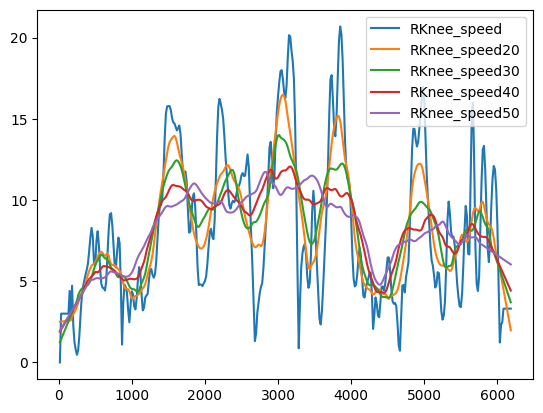

In [39]:
# plot all speeds for RKnee in df

import matplotlib.pyplot as plt
import seaborn as sns

sample = df

# get all columns with RKnee
cols = [x for x in sample.columns if 'RKnee_speed' in x]

# plot all columns
for col in cols:
    plt.plot(sample['Time'], sample[col], label=col)

plt.legend()
plt.show()




In [50]:
# load in all files with mt_centered
centeredfiles = glob.glob(datafolder + '/mt_centered_*')
print(centeredfiles)

['e:\\FLESH_ContinuousBodilyEffort\\TS_processing/TS_motiontracking\\mt_centered_0_1_0_p0.csv', 'e:\\FLESH_ContinuousBodilyEffort\\TS_processing/TS_motiontracking\\mt_centered_0_1_10_p1.csv', 'e:\\FLESH_ContinuousBodilyEffort\\TS_processing/TS_motiontracking\\mt_centered_0_1_11_p1.csv', 'e:\\FLESH_ContinuousBodilyEffort\\TS_processing/TS_motiontracking\\mt_centered_0_1_12_p1.csv', 'e:\\FLESH_ContinuousBodilyEffort\\TS_processing/TS_motiontracking\\mt_centered_0_1_13_p1.csv', 'e:\\FLESH_ContinuousBodilyEffort\\TS_processing/TS_motiontracking\\mt_centered_0_1_14_p1.csv', 'e:\\FLESH_ContinuousBodilyEffort\\TS_processing/TS_motiontracking\\mt_centered_0_1_15_p1.csv', 'e:\\FLESH_ContinuousBodilyEffort\\TS_processing/TS_motiontracking\\mt_centered_0_1_16_p1.csv', 'e:\\FLESH_ContinuousBodilyEffort\\TS_processing/TS_motiontracking\\mt_centered_0_1_17_p1.csv', 'e:\\FLESH_ContinuousBodilyEffort\\TS_processing/TS_motiontracking\\mt_centered_0_1_18_p0.csv', 'e:\\FLESH_ContinuousBodilyEffort\\TS_pr

## Interpolating 0 

In [51]:
# all the files are starting from 16ms but we want them to start from 0
# so we want to add 0 ms and interpolate the value

for file in centeredfiles:
    print('working on' + file)  
    # load in the file
    df = pd.read_csv(file)
    
    # insert a new row in the beginning with 0 ms
    newrow = df.iloc[0].copy()
    newrow['Time'] = 0

    df = pd.concat([pd.DataFrame([newrow]), df]).reset_index(drop=True)

    # resave
    df.to_csv(file, index=False)


working one:\FLESH_ContinuousBodilyEffort\TS_processing/TS_motiontracking\mt_centered_0_1_0_p0.csv
working one:\FLESH_ContinuousBodilyEffort\TS_processing/TS_motiontracking\mt_centered_0_1_10_p1.csv
working one:\FLESH_ContinuousBodilyEffort\TS_processing/TS_motiontracking\mt_centered_0_1_11_p1.csv
working one:\FLESH_ContinuousBodilyEffort\TS_processing/TS_motiontracking\mt_centered_0_1_12_p1.csv
working one:\FLESH_ContinuousBodilyEffort\TS_processing/TS_motiontracking\mt_centered_0_1_13_p1.csv
working one:\FLESH_ContinuousBodilyEffort\TS_processing/TS_motiontracking\mt_centered_0_1_14_p1.csv
working one:\FLESH_ContinuousBodilyEffort\TS_processing/TS_motiontracking\mt_centered_0_1_15_p1.csv
working one:\FLESH_ContinuousBodilyEffort\TS_processing/TS_motiontracking\mt_centered_0_1_16_p1.csv
working one:\FLESH_ContinuousBodilyEffort\TS_processing/TS_motiontracking\mt_centered_0_1_17_p1.csv
working one:\FLESH_ContinuousBodilyEffort\TS_processing/TS_motiontracking\mt_centered_0_1_18_p0.csv
w

For reaching to grasp, it is not uncommon to take a speed threshold of 15cm/s as a movement of the hand (e.g., based on wrist movement translation). We should be aware however, that while such values make sense for a particular articulator, other articulators may be less  mobile, and are judged to move much earlier relative to background noise micro movements. As such, we devised an 'empirical threshold' applied for the whole data, by calculating the percentile of the distributions of wrist speeds at 15cm/s, and then using that percentile to get the thresholds for the other articulators based on their observed speed distributions. The distributions were consistently long-tailed so we constructed log-transformed distributions. Supplemental figure S1, shows all the thresholds we determined with this emprical threshold procedure. (Wim)

## Calculate threshold for movement as percentage

In [42]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# dfs = [pd.read_csv(file_path) for file_path in folderstotrack]

# # concatenate all data into one
# df = pd.concat(dfs, ignore_index=True)

wrist_speed = []

# lets use arrays instead of df
for file in centeredfiles:
    df = pd.read_csv(file)
    wrist_speed.extend(df['RWrist_speed'].tolist())
    wrist_speed.extend(df['LWrist_speed'].tolist())

wrist_speed = np.array(wrist_speed)

# get rid of outliers based on Tukeys rule
Q1 = np.percentile(wrist_speed, 25)
Q3 = np.percentile(wrist_speed, 75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

wrist_speed = wrist_speed[(wrist_speed > lower_bound) & (wrist_speed < upper_bound)]


# what is the max value of the speed for wrists
# speed_max = df[['RWrist_speed', 'LWrist_speed']].max().max()

speed_15cm_percentage = 15 / wrist_speed.max() * 100

# what is 15 cm/s in %
#speed_15cm_percentage = 15 / speed_max * 100

print('15 cm/s is in % ' + str(speed_15cm_percentage))

# store the thresholds for other keypoints
dynamic_thresholds = {}

# left and right should be treated as one
combined_keypoints = [
    ('LElbow_speed', 'RElbow_speed'),
    ('LShoulder_speed', 'RShoulder_speed'),
    ('LKnee_speed', 'RKnee_speed'),
    ('LHip_speed', 'RHip_speed'),
    ('LAnkle_speed', 'RAnkle_speed'),
    ('LHeel_speed', 'RHeel_speed'), 
    ('LBigToe_speed', 'RBigToe_speed'),
    ('LSmallToe_speed', 'RSmallToe_speed')
]

for keypoint_pair in combined_keypoints:
    joint_speed = []
    for file in folderstotrack:
        df = pd.read_csv(file)
        joint_speed.extend(df[keypoint_pair[0]].tolist())
        joint_speed.extend(df[keypoint_pair[1]].tolist())
    joint_speed = np.array(joint_speed)
    dynamic_threshold = (speed_15cm_percentage / 100) * joint_speed.max()
    dynamic_thresholds[keypoint_pair] = dynamic_threshold

# collect remaining keypoints
speed_columns = [col for col in df.columns if 'speed' in col and all(key not in col for key in ['Wrist', 'Elbow', 'Shoulder', 'Knee', 'Hip', 'Ankle', 'Heel', 'BigToe', 'SmallToe'])
]

for keypoint in speed_columns:
    keypoint_speed = []
    for file in folderstotrack:
        df = pd.read_csv(file)
        keypoint_speed.extend(df[keypoint].tolist())

    keypoint_speed = np.array(keypoint_speed)
    dynamic_threshold = (speed_15cm_percentage / 100) * keypoint_speed.max()
    dynamic_thresholds[keypoint] = dynamic_threshold

for key, threshold in dynamic_thresholds.items():
    print(f'{key} threshold: {threshold}')

15 cm/s is in % 14.838139997397404
('LElbow_speed', 'RElbow_speed') threshold: 29.41884905078313
('LShoulder_speed', 'RShoulder_speed') threshold: 14.464364340601986
('LKnee_speed', 'RKnee_speed') threshold: 15.45234607970934
('LHip_speed', 'RHip_speed') threshold: 9.819380891940563
('LAnkle_speed', 'RAnkle_speed') threshold: 21.405892858237596
('LHeel_speed', 'RHeel_speed') threshold: 24.101081874231696
('LBigToe_speed', 'RBigToe_speed') threshold: 19.197425758475088
('LSmallToe_speed', 'RSmallToe_speed') threshold: 20.086653993973112
Head_speed threshold: 15.587675175509778
Neck_speed threshold: 17.35276641179739
Nose_speed threshold: 15.981094566112416


Note that taking percentage is sensitive to extreme values in the distribution. Therefore, in the next step we take percentile instead

## Calculate threshold for movement as percentile

In [52]:
# load in one file

sample = pd.read_csv(centeredfiles[0])
# get all the keypoint columns
keypoint_columns = [col for col in sample.columns if 'speed' in col]

# for each keypoint column, prepare empty list to store later the logged values
for keypoint in keypoint_columns:
    # create a list that has name of the keypoint
    globals()[keypoint] = []

all_keypoints = {}

for file in centeredfiles:
    df = pd.read_csv(file)
    for keypoint in keypoint_columns:
        # log the values
        globals()[keypoint].extend(np.log(df[keypoint].tolist()))
        all_keypoints[keypoint] = globals()[keypoint]

# Define combined keypoints pairs
combined_keypoints = [
    ('LElbow_speed', 'RElbow_speed'),
    ('LShoulder_speed', 'RShoulder_speed'),
    ('LKnee_speed', 'RKnee_speed'),
    ('LHip_speed', 'RHip_speed'),
    ('LHeel_speed', 'RHeel_speed'), 
    ('LWrist_speed', 'RWrist_speed')
]

for keypoint_pair in combined_keypoints:
    left_keypoint = keypoint_pair[0]
    right_keypoint = keypoint_pair[1]

    # combine logged values
    combined_logged = np.concatenate([all_keypoints[left_keypoint], all_keypoints[right_keypoint]])

    # store the combined values in the dictionary
    all_keypoints[keypoint_pair] = combined_logged

# get percentile of 15 cm/s in RWrist_speed
# get the tuple LWrist_speed and RWrist_speed
wrist_speed = all_keypoints[('LWrist_speed', 'RWrist_speed')]
# sort the RWrist_speed
wspeed_sorted = np.sort(wrist_speed)
# get the rank of 15 cm/s
threshold = np.log(20)
rank = np.searchsorted(wspeed_sorted, threshold, side='right')
percentile = rank / len(wrist_speed) *100
print('15 cm/s is in % ' + str(percentile))



C:\Users\kadava\AppData\Local\Temp\ipykernel_7132\3338075935.py:18: RuntimeWarning: divide by zero encountered in log
  globals()[keypoint].extend(np.log(df[keypoint].tolist()))
C:\Users\kadava\AppData\Local\Temp\ipykernel_7132\3338075935.py:18: RuntimeWarning: invalid value encountered in log
  globals()[keypoint].extend(np.log(df[keypoint].tolist()))
C:\Users\kadava\AppData\Local\Temp\ipykernel_7132\3338075935.py:18: RuntimeWarning: divide by zero encountered in log
  globals()[keypoint].extend(np.log(df[keypoint].tolist()))
C:\Users\kadava\AppData\Local\Temp\ipykernel_7132\3338075935.py:18: RuntimeWarning: divide by zero encountered in log
  globals()[keypoint].extend(np.log(df[keypoint].tolist()))
C:\Users\kadava\AppData\Local\Temp\ipykernel_7132\3338075935.py:18: RuntimeWarning: divide by zero encountered in log
  globals()[keypoint].extend(np.log(df[keypoint].tolist()))
C:\Users\kadava\AppData\Local\Temp\ipykernel_7132\3338075935.py:18: RuntimeWarning: divide by zero encountered 

15 cm/s is in % 51.00289121792555


C:\Users\kadava\AppData\Local\Temp\ipykernel_7132\3338075935.py:18: RuntimeWarning: divide by zero encountered in log
  globals()[keypoint].extend(np.log(df[keypoint].tolist()))
C:\Users\kadava\AppData\Local\Temp\ipykernel_7132\3338075935.py:18: RuntimeWarning: divide by zero encountered in log
  globals()[keypoint].extend(np.log(df[keypoint].tolist()))
C:\Users\kadava\AppData\Local\Temp\ipykernel_7132\3338075935.py:18: RuntimeWarning: divide by zero encountered in log
  globals()[keypoint].extend(np.log(df[keypoint].tolist()))
C:\Users\kadava\AppData\Local\Temp\ipykernel_7132\3338075935.py:18: RuntimeWarning: invalid value encountered in log
  globals()[keypoint].extend(np.log(df[keypoint].tolist()))
C:\Users\kadava\AppData\Local\Temp\ipykernel_7132\3338075935.py:18: RuntimeWarning: divide by zero encountered in log
  globals()[keypoint].extend(np.log(df[keypoint].tolist()))
C:\Users\kadava\AppData\Local\Temp\ipykernel_7132\3338075935.py:18: RuntimeWarning: divide by zero encountered 

In [55]:
# store the thresholds for other keypoints
dynamic_thresholds = {}
dynamic_thresholds_log = {}


for keypoint_pair in combined_keypoints:
    # access the lists associated to the keypoint pair
    array1 = all_keypoints[keypoint_pair[0]]
    array2 = all_keypoints[keypoint_pair[1]]
    # convert into numpy array
    array1 = np.array(array1)
    array2 = np.array(array2)

    # combine the two arrays
    joint_logged = np.concatenate([array1, array2])

    # check for NaN values
    if np.isnan(joint_logged).any():
        # handle NaN values
        joint_logged = joint_logged[~np.isnan(joint_logged)]

    # calculate the percentile
    dynamic_threshold_log = np.percentile(joint_logged, percentile)
    dynamic_threshold = np.exp(dynamic_threshold_log)

    # store the threshold
    dynamic_thresholds[keypoint_pair] = dynamic_threshold
    dynamic_thresholds_log[keypoint_pair] = dynamic_threshold_log

# create list of keypoint columns that are not in combined_keypoints
speed_columns = [col for col in df.columns if 'speed' in col and all(key not in col for key in ['Wrist', 'Elbow', 'Shoulder', 'Knee', 'Hip', 'Ankle', 'Heel'])
]


# loop over the remaining keypoints lists and find the value at this percentage

for keypoint in speed_columns:
    print(keypoint)
    # convert to array
    array = np.array(globals()[keypoint])

    # Check for NaN values
    if np.isnan(array).any():
        # Handle NaN values
        array = array[~np.isnan(array)]

    # check for inf values and -inf
    if np.isinf(array).any():
        # Handle inf values
        array = array[~np.isinf(array)]

    dynamic_threshold_log = np.percentile(array, percentile)
    print(dynamic_threshold_log)
    dynamic_threshold = np.exp(dynamic_threshold_log)
    print(dynamic_threshold)
    dynamic_thresholds[keypoint] = dynamic_threshold
    dynamic_thresholds_log[keypoint] = dynamic_threshold_log

for key, threshold in dynamic_thresholds.items():
    print(f'{key} threshold: {threshold}')

for key, threshold in dynamic_thresholds_log.items():
    print(f'{key} threshold: {threshold}')

Head_speed
1.9401001363707817
6.959447829594526
('LElbow_speed', 'RElbow_speed') threshold: 11.680177392026373
('LShoulder_speed', 'RShoulder_speed') threshold: 8.296017122795107
('LKnee_speed', 'RKnee_speed') threshold: 6.3932292092652565
('LHip_speed', 'RHip_speed') threshold: 7.202513944616447
('LHeel_speed', 'RHeel_speed') threshold: 3.539328032391575
('LWrist_speed', 'RWrist_speed') threshold: 19.966933089984792
Head_speed threshold: 6.959447829594526
('LElbow_speed', 'RElbow_speed') threshold: 2.4578931649582403
('LShoulder_speed', 'RShoulder_speed') threshold: 2.1157755349071485
('LKnee_speed', 'RKnee_speed') threshold: 1.855239494303973
('LHip_speed', 'RHip_speed') threshold: 1.9744301240547066
('LHeel_speed', 'RHeel_speed') threshold: 1.2639368877690167
('LWrist_speed', 'RWrist_speed') threshold: 2.994077559769186
Head_speed threshold: 1.9401001363707817


## Plot the thresholds for movement

('LElbow_speed', 'RElbow_speed')
[2.90832528 2.90832528 2.8906371  ... 0.59524303 0.54869309 0.49987   ]
('LShoulder_speed', 'RShoulder_speed')
[2.28757072 2.28757072 2.3131217  ... 1.28922951 1.27587209 1.26233382]
('LKnee_speed', 'RKnee_speed')
[2.03339378 2.03339378 2.02190738 ... 1.01463277 1.02253287 1.03037104]
('LHip_speed', 'RHip_speed')
[      -inf       -inf 3.29334545 ... 1.17004153 1.09797839 1.02031605]
('LHeel_speed', 'RHeel_speed')
[1.48681666 1.48681666 1.44308662 ... 0.95888441 0.95888441 0.95888441]


C:\Users\kadava\AppData\Local\Temp\ipykernel_7132\4040276043.py:60: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_labels)
C:\Users\kadava\AppData\Local\Temp\ipykernel_7132\4040276043.py:60: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_labels)
C:\Users\kadava\AppData\Local\Temp\ipykernel_7132\4040276043.py:60: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_labels)
C:\Users\kadava\AppData\Local\Temp\ipykernel_7132\4040276043.py:60: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(x_labels)
C:\Users\kadava\AppData\Local\Temp\ipykernel_7132\4040276043.py:60: UserWarning: set_ticklab

('LWrist_speed', 'RWrist_speed')
[3.95788066 3.95788066 3.95035818 ... 1.40054689 1.32765363 1.24902622]
Head_speed
[1.1592987486492992, 1.1592987486492992, 1.2011867640822613, 1.2413904889189855, 1.2800401521143077, 1.317251439218568, 1.353127580408059, 1.3877610767342639, 1.4212351372998893, 1.4401476493487748, 1.3986224757980699, 1.395167873035944, 1.4193649730470046, 1.4404080396909968, 1.4398746596784953, 1.4229444039851966, 1.4021689437830096, 1.4005332599406601, 1.4266639673125137, 1.4324628566765087, 1.4103673092316151, 1.3843380049934892, 1.3891339665157938, 1.4258095401221402, 1.4577546253912668, 1.451911379845512, 1.4090463588997868, 1.3511737946733244, 1.2799905887584808, 1.2314727370888128, 1.224086070245264, 1.2230047577814154, 1.2000814889613347, 1.1505141391890477, 1.0729885904096097, 0.9645049814031509, 0.8800411492786636, 0.847456062315293, 0.8367034652482135, 0.8427160585292304, 0.8988153519008271, 0.958762798610174, 0.9933328050641278, 1.038429768065263, 1.083823241

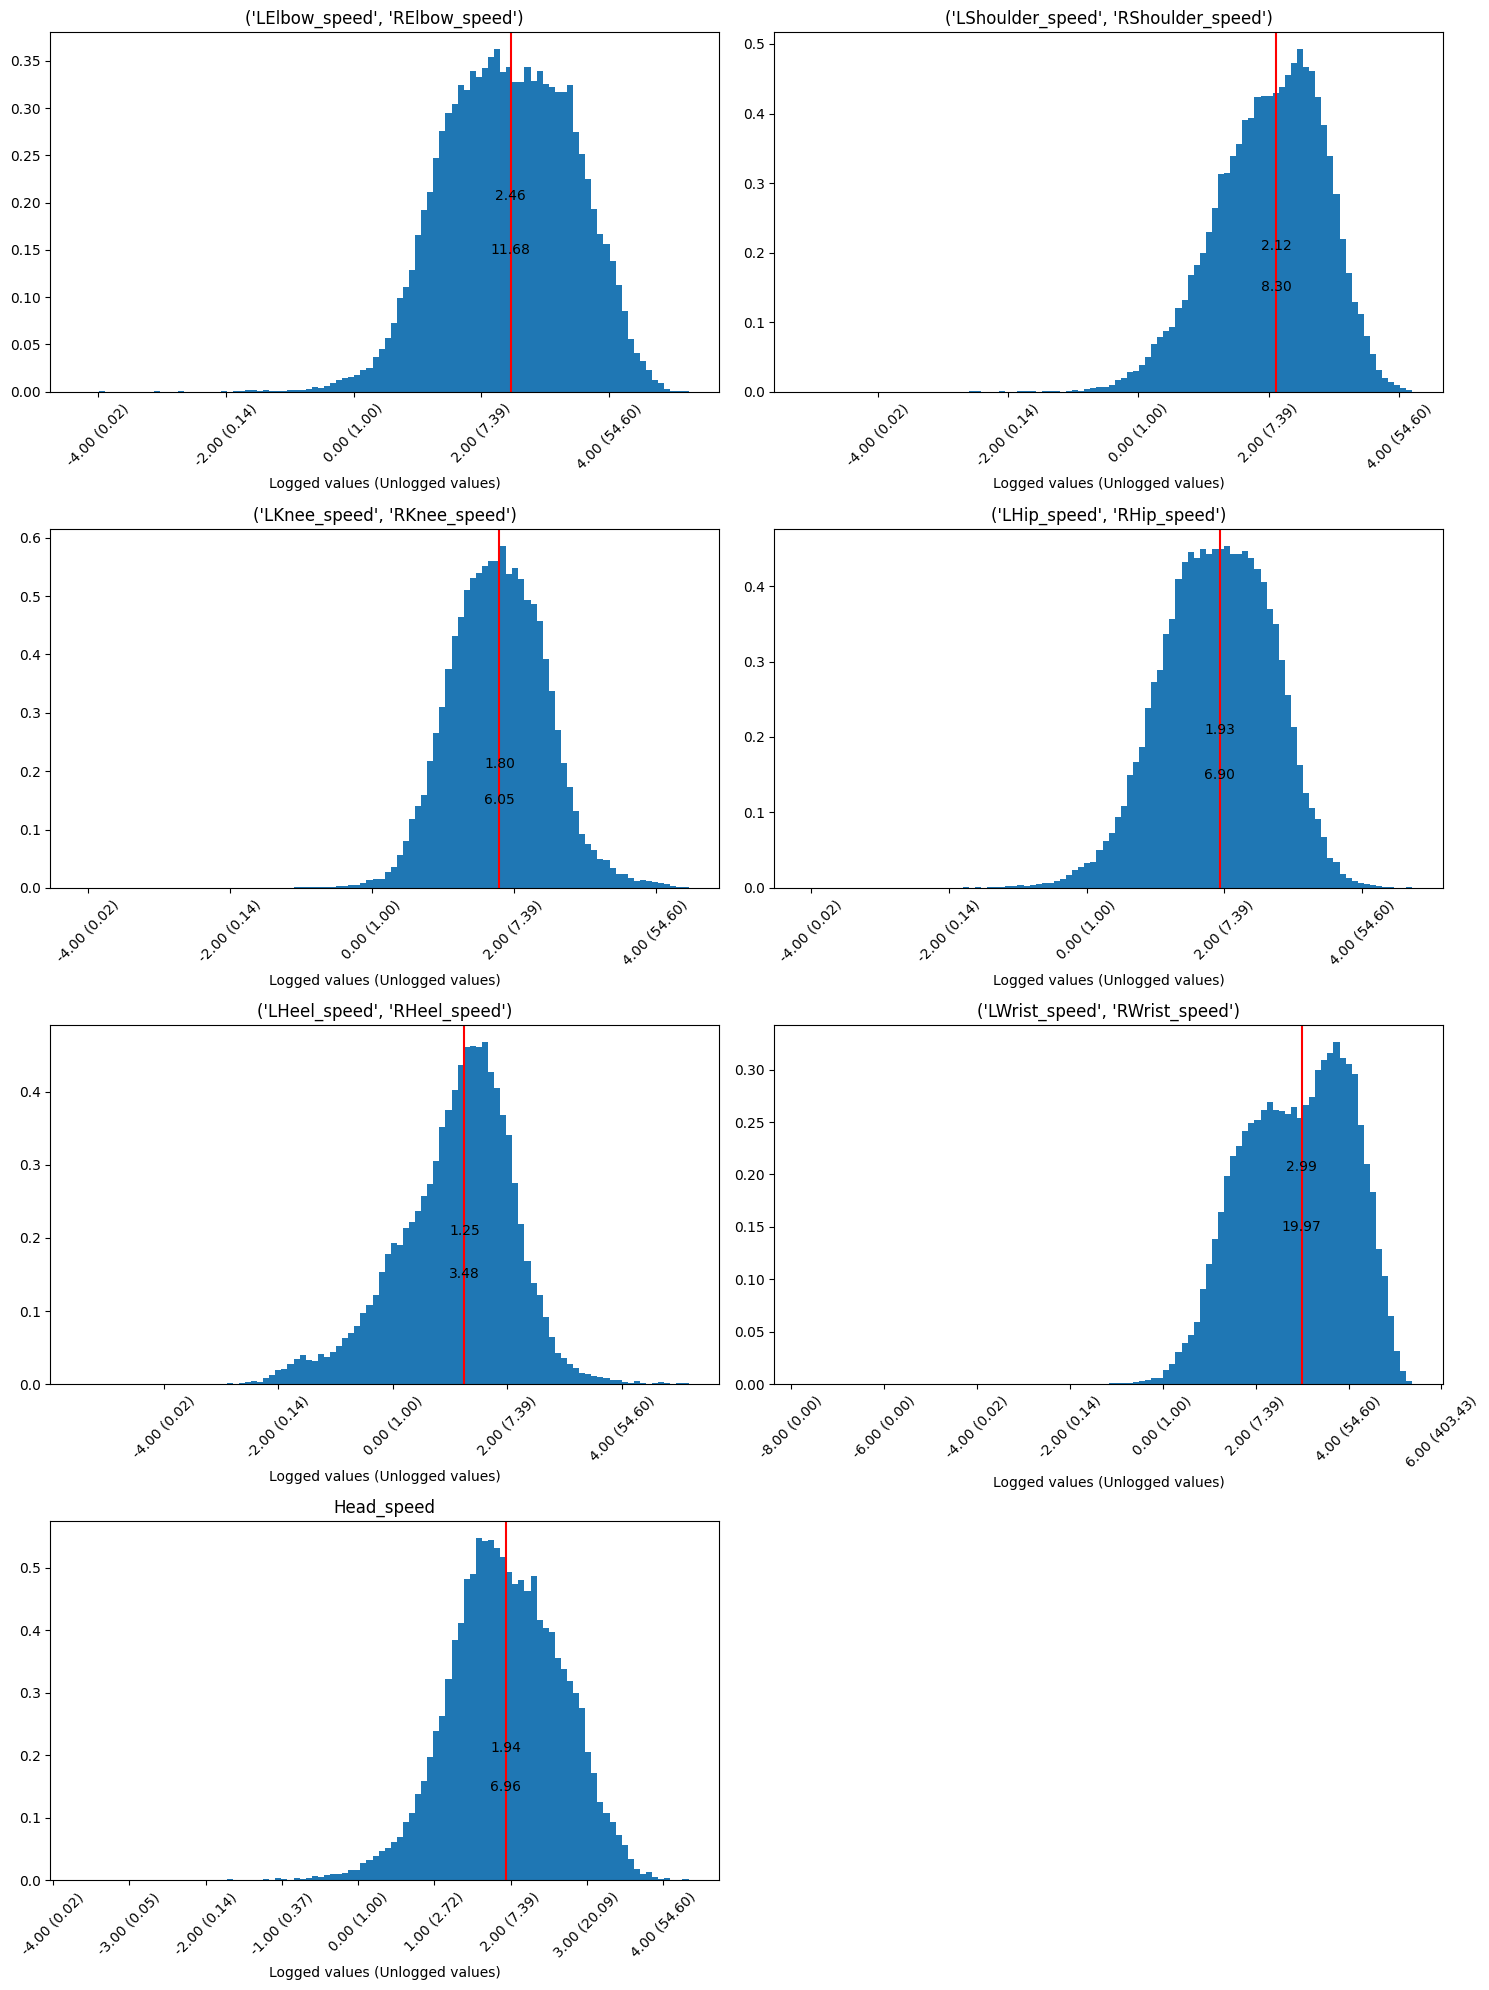

In [25]:
import matplotlib.pyplot as plt

# Define the number of subplots (one for each keypoint)
num_keypoints = len(dynamic_thresholds)
num_cols = 2  # Number of columns in the subplot grid
num_rows = (num_keypoints + num_cols - 1) // num_cols  # Number of rows needed

fig, axes = plt.subplots(num_rows, num_cols, figsize=(15, 5 * num_rows))

# Flatten the axes array for easy iteration if it is multidimensional
if num_rows > 1:
    axes = axes.flatten()

# Loop over keys in dynamic_thresholds
for i, keypoint in enumerate(dynamic_thresholds.keys()):
    logged_values = all_keypoints[keypoint]
    print(keypoint)
    print(logged_values)

    # if there any inf values skip them
    if np.isinf(logged_values).any():
        # Handle inf values
        logged_values = logged_values[~np.isinf(logged_values)]
    
    # Plot the histogram of the logged values
    axes[i].hist(logged_values, bins=100, density=True)
    axes[i].set_title(keypoint)
    
    # Determine which dynamic threshold to use based on keypoint type
    if isinstance(keypoint, tuple):
        # Combined keypoints
        threshold_log = dynamic_thresholds_log[keypoint]
        threshold = dynamic_thresholds[keypoint]
    else:
        # Individual keypoints
        threshold_log = dynamic_thresholds_log[keypoint]
        threshold = dynamic_thresholds[keypoint]
    
    # Add a vertical line for the threshold (logged value)
    axes[i].axvline(threshold_log, color='r')
    axes[i].text(threshold_log, 0.20, f'{threshold_log:.2f}', rotation=0, va='bottom', ha='center')  # Label in log
    
    # Calculate the corresponding unlogged threshold value
    threshold_unlog = np.exp(threshold_log)
    axes[i].text(np.log(threshold_unlog), 0.15, f'{threshold_unlog:.2f}', rotation=0, va='center', ha='center')  # Label in unlog
    
    # Get the current axis
    ax = axes[i]
    
    # Get the current tick positions on the x-axis
    x_ticks = ax.get_xticks()
    
    # Compute the corresponding unlogged values
    unlogged_values = np.exp(x_ticks)
    
    # Format the tick labels to include both logged and unlogged values
    x_labels = [f'{log_val:.2f} ({unlog_val:.2f})' for log_val, unlog_val in zip(x_ticks, unlogged_values)]
    
    # Set the new tick labels
    ax.set_xticklabels(x_labels)
    # Rotate x labels
    ax.tick_params(axis='x', rotation=45)
    
    # Set the labels for the x-axis
    ax.set_xlabel('Logged values (Unlogged values)')

# Remove any unused subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()


## Annotate movement based on thresholds

Note that y and z dimensions are swapped (such that z is vertical)

In [56]:
def determine_movement(value, threshold):
    if value > threshold:
        return 1
    else:
        return 0

In [57]:
annofolder = curfolder + '/MT_annotated'

### Annotate events

In [58]:
import pandas as pd
import scipy
import numpy as np

for file in centeredfiles:
    # last element is trialid
    trialid = file.split('\\')[-1]
    # get rid of .csv
    trialid = trialid.split('.')[0]
    print(trialid)

    # load it
    mt = pd.read_csv(file)

    # get the sampling rate
    sr = 1 / (mt['Time'].diff().mean())

    # show columns
    cols = mt.columns

    # put away 'Time' column from the list
    cols = [x for x in cols if x != 'Time']
    cols = [x for x in cols if x != 'TrialID']
    vvcols = [x for x in cols if 'vert_vel' in x]

    # keep only those with speed
    speedcols = [x for x in cols if 'speed' in x]

    # for each unique colname (cols), calculate speed from x and y dimensions (_x, _y)
    for col in speedcols:
        # annotate movement
        mt[col + '_movement'] = None
        # if the col starts with R or L, then we will find the threshold in a tuple
        if col.startswith('R'):
            threshold = dynamic_thresholds[(col.replace('R', 'L'), col)]
        elif col.startswith('L'):
            threshold = dynamic_thresholds[(col, col.replace('L', 'R'))]
        else:
            threshold = dynamic_thresholds[col]

        # determine movement
        mt[col + '_movement'] = mt[col].apply(lambda x: determine_movement(x, threshold))

        # annotate events
        mt[col + '_event'] = (mt[col + '_movement'] != mt[col + '_movement'].shift(1)) & (mt[col + '_movement'] == 1)
        mt[col + '_event'] = mt[col + '_event'].cumsum()
        # if there is no movement, then event is 0
        mt.loc[mt[col + '_movement'] == 0, col + '_event'] = 0

    for col in vvcols:
        # for each of these columns, create a col_movement column
        mt[col + '_movement'] = None
        # if the speed in col_speed is smaller than -15 or bigger than 15, then movement is 1, else 0
        mt.loc[(mt[col] >= 15) | (mt[col] <= -15), col + '_movement'] = 1
        mt.loc[(mt[col] < 15) & (mt[col] > -15), col + '_movement'] = 0
        # annotate events
        mt[col + '_movement_event'] = (mt[col + '_movement'] != mt[col + '_movement'].shift(1)) & (mt[col + '_movement'] == 1)
        mt[col + '_movement_event'] = mt[col + '_movement_event'].cumsum()
        # if there is no movement, then event is 0
        mt.loc[mt[col + '_movement'] == 0, col + '_movement_event'] = 0

    # get rid of all columns with _y, _x, _z
    mt = mt[[x for x in mt.columns if not any(y in x for y in ['_x', '_y', '_z'])]]
            
    # save the annotated file
    mt.to_csv(annofolder + '/' + trialid + '_annotated.csv', index=False)

mt_centered_0_1_0_p0
mt_centered_0_1_10_p1
mt_centered_0_1_11_p1
mt_centered_0_1_12_p1
mt_centered_0_1_13_p1
mt_centered_0_1_14_p1
mt_centered_0_1_15_p1
mt_centered_0_1_16_p1
mt_centered_0_1_17_p1
mt_centered_0_1_18_p0
mt_centered_0_1_19_p0
mt_centered_0_1_1_p0
mt_centered_0_1_20_p0
mt_centered_0_1_21_p0
mt_centered_0_1_22_p0
mt_centered_0_1_23_p0
mt_centered_0_1_24_p0
mt_centered_0_1_25_p0
mt_centered_0_1_26_p0
mt_centered_0_1_27_p1
mt_centered_0_1_28_p1
mt_centered_0_1_29_p1
mt_centered_0_1_2_p0
mt_centered_0_1_30_p1
mt_centered_0_1_31_p1
mt_centered_0_1_32_p1
mt_centered_0_1_33_p1
mt_centered_0_1_35_p1
mt_centered_0_1_36_p0
mt_centered_0_1_37_p0
mt_centered_0_1_38_p0
mt_centered_0_1_39_p0
mt_centered_0_1_3_p0
mt_centered_0_1_40_p0
mt_centered_0_1_41_p0
mt_centered_0_1_42_p0
mt_centered_0_1_43_p0
mt_centered_0_1_44_p0
mt_centered_0_1_45_p1
mt_centered_0_1_46_p1
mt_centered_0_1_47_p1
mt_centered_0_1_48_p1
mt_centered_0_1_49_p1
mt_centered_0_1_4_p0
mt_centered_0_1_50_p1
mt_centered_0_1

In [59]:
annofiles = glob.glob(annofolder + '/*.csv')
# skip those files that have ELAN in the name
annofiles = [x for x in annofiles if 'ELAN' not in x]
# keep only centered in
annofiles = [x for x in annofiles if 'centered' in x]
print(annofiles)


['e:\\FLESH_ContinuousBodilyEffort\\TS_processing/MT_annotated\\mt_centered_0_1_0_p0_annotated.csv', 'e:\\FLESH_ContinuousBodilyEffort\\TS_processing/MT_annotated\\mt_centered_0_1_10_p1_annotated.csv', 'e:\\FLESH_ContinuousBodilyEffort\\TS_processing/MT_annotated\\mt_centered_0_1_11_p1_annotated.csv', 'e:\\FLESH_ContinuousBodilyEffort\\TS_processing/MT_annotated\\mt_centered_0_1_12_p1_annotated.csv', 'e:\\FLESH_ContinuousBodilyEffort\\TS_processing/MT_annotated\\mt_centered_0_1_13_p1_annotated.csv', 'e:\\FLESH_ContinuousBodilyEffort\\TS_processing/MT_annotated\\mt_centered_0_1_14_p1_annotated.csv', 'e:\\FLESH_ContinuousBodilyEffort\\TS_processing/MT_annotated\\mt_centered_0_1_15_p1_annotated.csv', 'e:\\FLESH_ContinuousBodilyEffort\\TS_processing/MT_annotated\\mt_centered_0_1_16_p1_annotated.csv', 'e:\\FLESH_ContinuousBodilyEffort\\TS_processing/MT_annotated\\mt_centered_0_1_17_p1_annotated.csv', 'e:\\FLESH_ContinuousBodilyEffort\\TS_processing/MT_annotated\\mt_centered_0_1_18_p0_annota

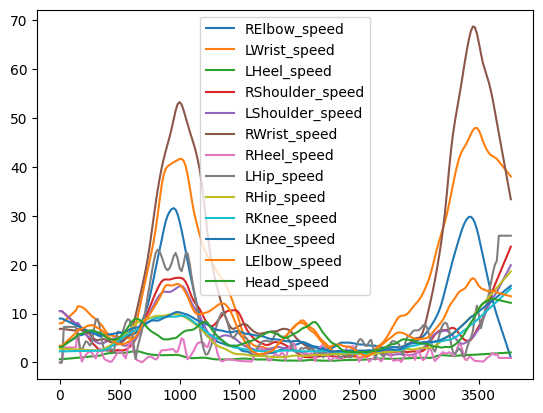

In [60]:
sample = pd.read_csv(annofiles[50])

# plot all speeds in sample
speedcols = [x for x in sample.columns if 'speed' in x]
# get out all that contains event or movement
speedcols = [x for x in speedcols if 'event' not in x]
speedcols = [x for x in speedcols if 'movement' not in x]

for col in speedcols:
    plt.plot(sample['Time'], sample[col], label=col)
plt.legend()
plt.show()

### Functions needed for annotation

In [69]:
## function to parse the events into chunks

# Function to get chunks from a column
def get_chunks(df, time_col, event_col):
    chunks = []
    current_chunk = None

    for idx, row in df.iterrows():
        if current_chunk is None:
            current_chunk = {'value': row[event_col], 'start_idx': idx, 'start_time': row[time_col]}
        elif row[event_col] != current_chunk['value']:
            current_chunk['end_idx'] = idx - 1
            current_chunk['end_time'] = df.loc[idx - 1, time_col]
            chunks.append(current_chunk)
            current_chunk = {'value': row[event_col], 'start_idx': idx, 'start_time': row[time_col]}
        if idx == len(df) - 1:
            current_chunk['end_idx'] = idx
            current_chunk['end_time'] = row[time_col]
            chunks.append(current_chunk)

    chunk_data = []
    for chunk in chunks:
        duration = chunk['end_time'] - chunk['start_time']
        chunk_data.append([chunk['value'], chunk['start_idx'], chunk['end_idx'], chunk['start_time'], chunk['end_time'], duration])

    chunks_df = pd.DataFrame(chunk_data, columns=['value', 'start_idx', 'end_idx', 'start_time', 'end_time', 'duration'])
    return chunks_df


## detect and merge short pauses

def detect_and_merge_short_pauses(chunk_df, col, df):
    short_pauses = []
    # Print rows that have value 0 and duration less than 250
    short_pause_rows = chunk_df[(chunk_df['value'] == 0) & (chunk_df['duration'] < 250)]
    
    # if short_pause_rows is not empty, loop over
    if not short_pause_rows.empty:
        # if these rows do not contain first and last row, append them to short_pauses
        for idx, row in short_pause_rows.iterrows():
            # if start_idx is not 0 and end_idx is not the last index, append to short_pauses
            if row['start_idx'] != 0 and row['end_idx'] != len(df) - 1:
                short_pauses.append(row)
    
        # If short pauses is empty, we do not need to merge anything
        if not short_pauses:
            print('We do not need to merge')
            df = df
            return df
        
        print('We need to merge')  
        # Check what is the value of the previous row and the next row in chunk
        for pause in short_pauses:
            # Get the index of the row in df
            idx = pause.name      
            # Get the index of the previous row
            prev_idx = idx - 1
            # Print the previous row
            #print('Previous row', chunk_df.loc[prev_idx])
            # Get the start index of the previous row
            new_start_index = chunk_df.loc[prev_idx, 'start_idx']
            # Value of the previous row
            prev_value = chunk_df.loc[prev_idx, 'value']
            # Get the index of the next row
            next_idx = idx + 1
            # Print the next row
            #print('Next row', chunk_df.loc[next_idx])
            # Get the end index of the next row
            new_end_idx = chunk_df.loc[next_idx, 'end_idx']
            # Everything from new_start_index to new_end_idx should be merged and named as previous value
            # In the original dataframe, set the value to the previous value in this range
            df.loc[new_start_index:new_end_idx, col] = prev_value

    return df


## merge nonzero segments
def merge_nonzero_segments(chunks):
    merged_all = []

    for df in chunks:
        # Filter rows with non-zero values
        non_zero_rows = df[df['value'] != 0].reset_index(drop=True)
        
        #print(non_zero_rows)
        # Initialize list to store merged segments
        merged_segments = []

        # If the non_zero rows are empty, we do not need to do anything
        if non_zero_rows.empty:
            print('No non-zero rows')
            continue
        else:
            # Initialize variables to track current segment
            current_segment = non_zero_rows.iloc[0].copy()

            # Iterate through non-zero rows to merge consecutive segments
            for i in range(1, len(non_zero_rows)):
                row = non_zero_rows.iloc[i]
            
                if current_segment['end_idx'] + 1 == row['start_idx']:
                    # Merge segments
                    current_segment['end_idx'] = row['end_idx']
                    current_segment['duration'] += row['duration']
                else:
                    # Append current segment to merged segments list
                    merged_segments.append(current_segment)
                    # Start new segment
                    current_segment = row.copy()

            # Append the last segment
            merged_segments.append(current_segment)

            # Convert list of merged segments to DataFrame
            merged_df = pd.DataFrame(merged_segments)

            # Append to merged_all
            merged_all.append(merged_df)

    return merged_all

## process fake events

def process_fake_events(chunk, df_all):
    #for chunk in chunks:
    col = chunk['column'][0]
    df = chunk

    ## FAKE EVENTS
    nomov = []  
    # Print rows that don't have value 0 and duration less than 200
    fake_event_rows = df[(df['value'] != 0) & (df['duration'] < 400)]  # previously 200
    #print(fake_event_rows)
    # Add those rows to nomov
    for idx, row in fake_event_rows.iterrows():
        nomov.append(row)
    
    # If nomov is empty, we do not need to do anything
    if not nomov:
        print('No fake events found')
        df_all = df_all
    else:
        # These fake events need to be turned into 0s in the original dataframe
        print('We need to turn fake events into 0s')
        # For each row in nomov, set the value in the original dataframe to 0
        for fake_event in nomov:
            start = int(fake_event['start_idx'])
            end = int(fake_event['end_idx'])
            # In the original dataframe, set the value to 0 in this range
            df_all.loc[start:end, col] = 0

    return df_all


# Function to check if there is any overlap
def check_overlap(non_zero_df, zero_df, wrist_name):
    first_non_zero = non_zero_df.iloc[0]
    last_non_zero = non_zero_df.iloc[-1]

    startstodel = []
    endstodel = []
    
    for zero_row in zero_df.itertuples(index=False):
        # Check if the first non-zero chunk is completely within the zero chunk
        if first_non_zero.start_idx >= zero_row.start_idx and first_non_zero.end_idx <= zero_row.end_idx:
            print(f"First non-zero chunk {first_non_zero.start_idx}-{first_non_zero.end_idx} in {first_non_zero.column} is completely within zero chunk {zero_row.start_idx}-{zero_row.end_idx} in {wrist_name}_vert_vel_movement_event")
            # attach the start and end index of this chunk
            startstodel.append(first_non_zero.start_idx)
            endstodel.append(first_non_zero.end_idx)
            
        
        # Check if the last non-zero chunk is completely within the zero chunk
        if last_non_zero.start_idx >= zero_row.start_idx and last_non_zero.end_idx <= zero_row.end_idx:
            print(f"Last non-zero chunk {last_non_zero.start_idx}-{last_non_zero.end_idx} in {last_non_zero.column} is completely within zero chunk {zero_row.start_idx}-{zero_row.end_idx} in {wrist_name}_vert_vel_movement_event")
            # attach
            startstodel.append(last_non_zero.start_idx)
            endstodel.append(last_non_zero.end_idx)

    return startstodel, endstodel


### Loop over files and annotate events

In [79]:
sample = pd.read_csv(annofiles[0])
eventcols = [x for x in sample.columns if 'event' in x]
eventcols = [x for x in eventcols if 'Wrist' not in x]

for file in annofiles:
    print('working on ' + file)
    ### file
    file_df = pd.read_csv(file)
    trialid = file_df['TrialID'][0]

    ##### BODY EXCEPT WRIST #####   

    #### merging short pauses
    # Initialize variables
    chunks = []
    current_chunk = None

    # Dictionary to store results for each column
    chunk_results = {}

    # Loop through each event column and apply the function
    for col in eventcols:
        chunks_df = get_chunks(file_df, 'Time', col)
        chunk_results[col] = chunks_df

    # turn the dictionary into a list, also with info about column
    chunks = []
    for col, df in chunk_results.items():
        df['column'] = col
        chunks.append(df)

    # merge short pauses
    for chunk in chunks:
        col = chunk['column'][0]
        df = chunk
        file_df1 = detect_and_merge_short_pauses(df, col, file_df)

    #### merging non-zero segments
    # apply the chunk function again on the new dataframe
    chunk_results_new = {}

    # Loop through each event column and apply the function
    for col in eventcols:
        chunks_df = get_chunks(file_df1, 'Time', col)
        chunk_results_new[col] = chunks_df

    # turn the dictionary into a list, also with info about column
    chunks_new = []
    for col, df in chunk_results_new.items():
        df['column'] = col
        chunks_new.append(df)

    # merge nonzero segments
    merged_all = merge_nonzero_segments(chunks_new)

    for chunk in merged_all:
        for _, row in chunk.iterrows():
            start = row['start_idx']
            end = row['end_idx']
            value = row['value']
            column = row['column']

            # Update the corresponding column in file_df
            file_df1.loc[start:end, column] = value

    ### process fake events
    # perform the chunk function again
    chunk_results_final = {}

    # Loop through each event column and apply the function
    for col in eventcols:
        chunks_df = get_chunks(file_df1, 'Time', col)
        chunk_results_final[col] = chunks_df

    # convert dict into list
    chunks_final = []

    # convert
    for col, df in chunk_results_final.items():
        df['column'] = col
        chunks_final.append(df)

    # get rid of fake events
    for chunk in chunks_final:
        # process fake events
        file_df2 = process_fake_events(chunk, file_df1)
    
    #### WRIST ####
    # lets do chunks again, but only on wrist event cols
    wristcols = [x for x in file_df2.columns if 'Wrist' in x]

    # keep only those that have movement and event in
    wristcols = [x for x in wristcols if 'event' in x]

    ### merging short pauses
    # now the chunk function
    wchunk_results = {}

    # Loop through each event column and apply the function
    for col in wristcols:
        wchunks_df = get_chunks(file_df2, 'Time', col)
        wchunk_results[col] = wchunks_df

    # convert dict into list
    wchunks = []

    # convert
    for col, df in wchunk_results.items():
        df['column'] = col
        wchunks.append(df)

    # merge short pauses
    for chunk in wchunks:
        print(chunk)
        col = chunk['column'][0]
        df = chunk
        # detect and merge short pauses
        file_df3 = detect_and_merge_short_pauses(df, col, file_df2)

    ### merging non-zero segments
    # apply the chunk function again on the new dataframe
    wchunk_results_new = {}

    # Loop through each event column and apply the function
    for col in wristcols:
        wchunks_df = get_chunks(file_df3, 'Time', col)
        wchunk_results_new[col] = wchunks_df

    # convert dict into list
    wchunks_new = []

    # convert
    for col, df in wchunk_results_new.items():
        df['column'] = col
        wchunks_new.append(df)

    # merge events
    wmerged_all = merge_nonzero_segments(wchunks_new)

    for chunk in wmerged_all:
        for _, row in chunk.iterrows():
            print(row)
            start = row['start_idx']
            end = row['end_idx']
            value = row['value']
            column = row['column']

            # Update the corresponding column in file_df
            file_df3.loc[start:end, column] = value
        
    ### process fake events
    # perform the chunk function again
    wchunk_results_final = {}

    # Loop through each event column and apply the function
    for col in wristcols:
        wchunks_df = get_chunks(file_df3, 'Time', col)
        wchunk_results_final[col] = wchunks_df

    # convert dict into list
    wchunks_final = []

    # convert
    for col, df in wchunk_results_final.items():
        df['column'] = col
        wchunks_final.append(df)

    # get rid of fake events
    for chunk in wchunks_final:
        # process fake events
        file_df4 = process_fake_events(chunk, file_df3)

    ### check for overlap
    # perform the chunk function again
    wchunk_results_final = {}

    # Loop through each event column and apply the function
    for col in wristcols:
        wchunks_df = get_chunks(file_df4, 'Time', col)
        wchunk_results_final[col] = wchunks_df

    # convert dict into list
    wchunks_results_final_list = []

    # convert
    for col, df in wchunk_results_final.items():
        df['column'] = col
        wchunks_results_final_list.append(df)

    print(wchunks_results_final_list)

    # find the chunk in wchunks_results_final_list tHAT HAS column value RWrist_speed_event
    rightspeed = next((df for df in wchunks_results_final_list if 'RWrist_speed_event' in df['column'].values), None)
    leftspeed = next((df for df in wchunks_results_final_list if 'LWrist_speed_event' in df['column'].values), None)
    rightvel = next((df for df in wchunks_results_final_list if 'RWrist_vert_vel_movement_event' in df['column'].values), None)
    leftvel = next((df for df in wchunks_results_final_list if 'LWrist_vert_vel_movement_event' in df['column'].values), None)

    lefttocheck = leftspeed[leftspeed['value'] != 0]
    #print(lefttocheck)
    righttocheck = rightspeed[rightspeed['value'] != 0]
    #print(righttocheck)

    leftzero = leftvel[leftvel['value'] == 0]
    rightzero = rightvel[rightvel['value'] == 0]

    # if lefttocheck is not empty, check for overlaps
    if not lefttocheck.empty:
        print("Checking LWrist_event vs LWrist_vv_event")
        sindex1, eindex1 = check_overlap(lefttocheck, leftzero, "LWrist")
        # replace the values in the original dataframe with 0
        for start, end in zip(sindex1, eindex1):
            file_df4.loc[start:end, 'LWrist_speed_event'] = 0

    # if righttocheck is not empty, check for overlaps
    if not righttocheck.empty:
        print("\nChecking RWrist_event vs RWrist_vv_event")
        sindex2, eindex2 =check_overlap(righttocheck, rightzero, "RWrist")
        # replace the values in the original dataframe with 0
        for start, end in zip(sindex2, eindex2):
            # within this indices, replace the values with 0
            file_df4.loc[start:end, 'RWrist_speed_event'] = 0

    ### SAVING

    # make copy of file_df that has only 'event' columns in
    df_final = file_df4.copy()
    # drop other columns
    df_final = df_final[[x for x in df_final.columns if 'event' in x or 'Time' in x or 'TrialID' in x]]

    #for each column, everywhere where is 0, put 'nomovement', elsewhere 'movement'
    for col in df_final.columns:
        if 'event' in col:
            df_final[col] = np.where(df_final[col] == 0, 'nomovement', 'movement')

    # save the annotated file
    df_final.to_csv(annofolder + '/' + trialid + '_ELAN_anno.csv', index=False)


    

working on e:\FLESH_ContinuousBodilyEffort\TS_processing/MT_annotated\mt_centered_0_1_0_p0_annotated.csv
We need to merge
We need to merge
We need to turn fake events into 0s
We need to turn fake events into 0s
No fake events found
We need to turn fake events into 0s
No fake events found
We need to turn fake events into 0s
No fake events found
No fake events found
We need to turn fake events into 0s
We need to turn fake events into 0s
We need to turn fake events into 0s
   value  start_idx  end_idx   start_time     end_time     duration  \
0      1          0       18     0.000000   300.000000   300.000000   
1      0         19       89   316.666667  1483.333333  1166.666667   
2      2         90      126  1500.000000  2100.000000   600.000000   
3      0        127      214  2116.666667  3566.666667  1450.000000   
4      3        215      243  3583.333333  4050.000000   466.666667   
5      0        244      299  4066.666667  4983.333333   916.666667   

               column  
0  

In [80]:
df_final

,Time,TrialID,RElbow_speed_event,LWrist_speed_event,LHeel_speed_event,RShoulder_speed_event,LShoulder_speed_event,RWrist_speed_event,RHeel_speed_event,LHip_speed_event,RHip_speed_event,RKnee_speed_event,LKnee_speed_event,LElbow_speed_event,Head_speed_event,LWrist_vert_vel_movement_event,RWrist_vert_vel_movement_event
0,0.000000,0_2_9_p0,nomovement,nomovement,nomovement,nomovement,nomovement,nomovement,nomovement,nomovement,movement,movement,movement,nomovement,nomovement,nomovement,nomovement
1,16.666667,0_2_9_p0,nomovement,nomovement,nomovement,nomovement,nomovement,nomovement,nomovement,nomovement,movement,movement,movement,nomovement,nomovement,nomovement,nomovement
2,33.333333,0_2_9_p0,nomovement,nomovement,nomovement,nomovement,nomovement,nomovement,nomovement,movement,movement,movement,movement,nomovement,nomovement,nomovement,nomovement
3,50.000000,0_2_9_p0,nomovement,nomovement,nomovement,movement,nomovement,nomovement,nomovement,movement,movement,movement,movement,nomovement,nomovement,nomovement,nomovement
4,66.666667,0_2_9_p0,nomovement,nomovement,nomovement,movement,movement,nomovement,nomovement,movement,movement,movement,movement,nomovement,nomovement,nomovement,nomovement
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
228,3800.000000,0_2_9_p0,nomovement,nomovement,nomovement,nomovement,nomovement,nomovement,nomovement,nomovement,nomovement,nomovement,nomovement,nomovement,nomovement,nomovement,nomovement
229,3816.666667,0_2_9_p0,nomovement,nomovement,nomovement,nomovement,nomovement,nomovement,nomovement,nomovement,nomovement,nomovement,nomovement,nomovement,nomovement,nomovement,nomovement
230,3833.333333,0_2_9_p0,nomovement,nomovement,nomovement,nomovement,nomovement,nomovement,nomovement,nomovement,nomovement,nomovement,nomovement,nomovement,nomovement,nomovement,nomovement
231,3850.000000,0_2_9_p0,nomovement,nomovement,nomovement,nomovement,nomovement,nomovement,nomovement,nomovement,nomovement,nomovement,nomovement,nomovement,nomovement,nomovement,nomovement


In [81]:
elanfiles = glob.glob(annofolder + '/*ELAN_anno.csv')

# group mapping
group_mapping = {
    'Head_speed_event': 'head_mov',
    'RShoulder_speed_event': 'upper_body',
    'LShoulder_speed_event': 'upper_body',
    'RWrist_speed_event': 'arms',
    'LWrist_speed_event': 'arms',
    'RHip_speed_event': 'lower_body',
    'LHip_speed_event': 'lower_body',
    'RKnee_speed_event': 'lower_body',
    'LKnee_speed_event': 'lower_body',
    'RAnkle_speed_event': 'lower_body',
    'LAnkle_speed_event': 'lower_body',
    'RHeel_speed_event': 'lower_body',
    'LHeel_speed_event': 'lower_body'}
    # skipping elbows for now
    
# Extract unique groups
groups = set(group_mapping.values())

# for each file, annotate the groups
for file in elanfiles:
    print('working on ' + file)
    # load the file
    df = pd.read_csv(file)

    # Initialize new columns for each group with 'nomovement'
    for group in groups:
        df[group] = 'nomovement'

    # Iterate over each row and update the group columns
    for index, row in df.iterrows():
        for keypoint, status in row.items():
            if keypoint in group_mapping and status == 'movement':
                group = group_mapping[keypoint]
                df.at[index, group] = 'movement'

    # create column 'movement_in_trial' that checks first row of arms, lower_body, upper_body, head_mov where there is a movement in any of those and last one, and everything in between is movement, elsewhere it is nomovement
    df['movement_in_trial'] = 'nomovement'
    # check what is the first row in arms, lower_body, upper_body, head_mov where there is movement
    first_movement = df[(df['arms'] == 'movement') | (df['lower_body'] == 'movement') | (df['upper_body'] == 'movement') | (df['head_mov'] == 'movement')].index[0]
    last_movement = df[(df['arms'] == 'movement') | (df['lower_body'] == 'movement') | (df['upper_body'] == 'movement') | (df['head_mov'] == 'movement')].index[-1]

    # everything in between is movement
    df.loc[first_movement:last_movement, 'movement_in_trial'] = 'movement'


    # get rid of all event columns
    df = df[[x for x in df.columns if 'event' not in x]]

    # save the annotated file
    df.to_csv(file.replace('ELAN_anno', 'ELAN_tiers'), index=False)



working on e:\FLESH_ContinuousBodilyEffort\TS_processing/MT_annotated\0_1_0_p0_ELAN_anno.csv
working on e:\FLESH_ContinuousBodilyEffort\TS_processing/MT_annotated\0_1_10_p1_ELAN_anno.csv
working on e:\FLESH_ContinuousBodilyEffort\TS_processing/MT_annotated\0_1_11_p1_ELAN_anno.csv
working on e:\FLESH_ContinuousBodilyEffort\TS_processing/MT_annotated\0_1_12_p1_ELAN_anno.csv
working on e:\FLESH_ContinuousBodilyEffort\TS_processing/MT_annotated\0_1_13_p1_ELAN_anno.csv
working on e:\FLESH_ContinuousBodilyEffort\TS_processing/MT_annotated\0_1_14_p1_ELAN_anno.csv
working on e:\FLESH_ContinuousBodilyEffort\TS_processing/MT_annotated\0_1_15_p1_ELAN_anno.csv
working on e:\FLESH_ContinuousBodilyEffort\TS_processing/MT_annotated\0_1_16_p1_ELAN_anno.csv
working on e:\FLESH_ContinuousBodilyEffort\TS_processing/MT_annotated\0_1_17_p1_ELAN_anno.csv
working on e:\FLESH_ContinuousBodilyEffort\TS_processing/MT_annotated\0_1_18_p0_ELAN_anno.csv
working on e:\FLESH_ContinuousBodilyEffort\TS_processing/MT_a

## Create ELAN files

In [82]:
from xml.etree import ElementTree as ET

# Function to create ELAN file
def create_eaf(chunks_dict, output_file):
    annotation_document = ET.Element('ANNOTATION_DOCUMENT', {
        'xmlns:xsi': "http://www.w3.org/2001/XMLSchema-instance",
        'AUTHOR': "",
        'DATE': "2024-05-28T11:54:22+01:00",
        'FORMAT': "3.0",
        'VERSION': "3.0",
        'xsi:noNamespaceSchemaLocation': "http://www.mpi.nl/tools/elan/EAFv3.0.xsd"
    })
    
    header = ET.SubElement(annotation_document, 'HEADER', {'MEDIA_FILE': "", 'TIME_UNITS': "milliseconds"})
    ET.SubElement(header, 'MEDIA_DESCRIPTOR', {
        'MEDIA_URL': "file:///path_to_your_file.wav",
        'MIME_TYPE': "audio/x-wav"
    })
    ET.SubElement(header, 'MEDIA_DESCRIPTOR', {
        'MEDIA_URL': "file:///path_to_your_file.avi",
        'MIME_TYPE': "video/*",
        'RELATIVE_MEDIA_URL': "./path_to_your_file.avi"
    })
    ET.SubElement(header, 'PROPERTY', {'NAME': "URN"}).text = "urn:nl-mpi-tools-elan-eaf:73467978-4930-486d-a56b-fa6acb05e357"
    ET.SubElement(header, 'PROPERTY', {'NAME': "lastUsedAnnotationId"}).text = "3"
    
    time_order = ET.SubElement(annotation_document, 'TIME_ORDER')
    ts_id_counter = 1
    time_slot_map = {}
    
    # Generate time slots for all chunks
    for group, group_chunks in chunks_dict.items():
        for _, chunk in group_chunks.iterrows():
            start_ts_id = f'ts{ts_id_counter}'
            if chunk['start_time'] not in time_slot_map:
                ET.SubElement(time_order, 'TIME_SLOT', {'TIME_SLOT_ID': start_ts_id, 'TIME_VALUE': str(int(chunk['start_time']))})
                time_slot_map[chunk['start_time']] = start_ts_id
                ts_id_counter += 1
            else:
                start_ts_id = time_slot_map[chunk['start_time']]

            end_ts_id = f'ts{ts_id_counter}'
            if chunk['end_time'] not in time_slot_map:
                ET.SubElement(time_order, 'TIME_SLOT', {'TIME_SLOT_ID': end_ts_id, 'TIME_VALUE': str(int(chunk['end_time']))})
                time_slot_map[chunk['end_time']] = end_ts_id
                ts_id_counter += 1
            else:
                end_ts_id = time_slot_map[chunk['end_time']]

    # Create the tiers
    for group, group_chunks in chunks_dict.items():
        tier = ET.SubElement(annotation_document, 'TIER', {
            'LINGUISTIC_TYPE_REF': "mov_detect",
            'TIER_ID': group
        })
        for i, chunk in group_chunks.iterrows():
            start_ts_id = time_slot_map[chunk['start_time']]
            end_ts_id = time_slot_map[chunk['end_time']]
            annotation_id = f'{group}_a{i + 1}'
            annotation = ET.SubElement(tier, 'ANNOTATION')
            alignable_annotation = ET.SubElement(annotation, 'ALIGNABLE_ANNOTATION', {
                'ANNOTATION_ID': annotation_id,
                'TIME_SLOT_REF1': start_ts_id,
                'TIME_SLOT_REF2': end_ts_id
            })
            ET.SubElement(alignable_annotation, 'ANNOTATION_VALUE').text = chunk['value']
    
    # Add constraints and linguistic types
    ET.SubElement(annotation_document, 'LINGUISTIC_TYPE', {
        'GRAPHIC_REFERENCES': "false",
        'LINGUISTIC_TYPE_ID': "mov_detect",
        'TIME_ALIGNABLE': "true"
    })
    constraints = [
        ("Time subdivision of parent annotation's time interval, no time gaps allowed within this interval", "Time_Subdivision"),
        ("Symbolic subdivision of a parent annotation. Annotations referring to the same parent are ordered", "Symbolic_Subdivision"),
        ("1-1 association with a parent annotation", "Symbolic_Association"),
        ("Time alignable annotations within the parent annotation's time interval, gaps are allowed", "Included_In")
    ]
    for desc, stereotype in constraints:
        ET.SubElement(annotation_document, 'CONSTRAINT', {'DESCRIPTION': desc, 'STEREOTYPE': stereotype})
    
    tree = ET.ElementTree(annotation_document)
    tree.write(output_file, encoding='UTF-8', xml_declaration=True)

In [ ]:
elanfiles = glob.glob(annofolder + '/*ELAN_tiers.csv')

for file in elanfiles:
    print('working on ' + file)
    # load the file
    df = pd.read_csv(file)

    # get chunks
    parent_chunks = get_chunks(df, 'Time', 'movement_in_trial')
    head_chunks = get_chunks(df, 'Time', 'head_mov')
    upper_body_chunks = get_chunks(df, 'Time', 'upper_body')
    arms_chunks = get_chunks(df, 'Time', 'arms')
    lower_body_chunks = get_chunks(df, 'Time', 'lower_body')

    # Adjust end time of each chunk to be the start time of the next chunk
    # for each except last row, end time is the start time of the next row
    # do it for every row except the last one
    parent_chunks['end_time'][0:-1] = parent_chunks['start_time'][1:]
    head_chunks['end_time'][0:-1] = head_chunks['start_time'][1:]
    upper_body_chunks['end_time'][0:-1] = upper_body_chunks['start_time'][1:]
    arms_chunks['end_time'][0:-1] = arms_chunks['start_time'][1:]
    lower_body_chunks['end_time'][0:-1] = lower_body_chunks['start_time'][1:]

    # chunk dictionary
    chunks_dict = {
        'movement_in_trial': parent_chunks,
        'head_mov': head_chunks,
        'upper_body': upper_body_chunks,
        'arms': arms_chunks,
        'lower_body': lower_body_chunks
    }
    
    # create the eaf file
    create_eaf(chunks_dict, file.replace('.csv', '.eaf'))


Note that we could also proceed the other way - first check overlap, then perform the merge and detection of fake events. Is something better?

## Editing eaf files

In [62]:
import xml.etree.ElementTree as ET
import glob

def add_nomovement_annotations(xml_file_path, newfilepath):
    # Load the XML file
    tree = ET.parse(xml_file_path)
    root = tree.getroot()

    # Extract all time slots
    time_slots = {}
    for time_slot in root.find('TIME_ORDER').findall('TIME_SLOT'):
        time_slots[time_slot.attrib['TIME_SLOT_ID']] = int(time_slot.attrib['TIME_VALUE'])

    # Sort time slots by TIME_VALUE
    sorted_time_slots = sorted(time_slots.items(), key=lambda x: x[1])
    time_slot_ids = [ts[0] for ts in sorted_time_slots]
    time_values = [ts[1] for ts in sorted_time_slots]

    # Loop over all tiers
    for tier in root.findall('TIER'):
        annotations = tier.findall('ANNOTATION/ALIGNABLE_ANNOTATION')

        if not annotations:
            # If no annotations exist, add a single 'nomovement' annotation covering the whole tier
            new_annotation = ET.Element('ANNOTATION')
            alignable_annotation = ET.SubElement(new_annotation, 'ALIGNABLE_ANNOTATION')
            alignable_annotation.set('TIME_SLOT_REF1', time_slot_ids[0])
            alignable_annotation.set('TIME_SLOT_REF2', time_slot_ids[-1])
            annotation_value = ET.SubElement(alignable_annotation, 'ANNOTATION_VALUE')
            annotation_value.text = 'nomovement'
            tier.append(new_annotation)
        else:
            # Sort annotations by start time
            sorted_annotations = sorted(annotations, key=lambda x: time_slots[x.attrib['TIME_SLOT_REF1']])
            
            # Handle the first annotation
            first_annotation = sorted_annotations[0]
            first_start_time = time_slots[first_annotation.attrib['TIME_SLOT_REF1']]
            if first_start_time > time_values[0]:
                new_annotation = ET.Element('ANNOTATION')
                alignable_annotation = ET.SubElement(new_annotation, 'ALIGNABLE_ANNOTATION')
                alignable_annotation.set('TIME_SLOT_REF1', time_slot_ids[0])
                alignable_annotation.set('TIME_SLOT_REF2', first_annotation.attrib['TIME_SLOT_REF1'])
                annotation_value = ET.SubElement(alignable_annotation, 'ANNOTATION_VALUE')
                annotation_value.text = 'nomovement'
                tier.append(new_annotation)

            # Handle gaps between annotations
            for i in range(len(sorted_annotations) - 1):
                current_annotation = sorted_annotations[i]
                next_annotation = sorted_annotations[i + 1]
                current_end_time = time_slots[current_annotation.attrib['TIME_SLOT_REF2']]
                next_start_time = time_slots[next_annotation.attrib['TIME_SLOT_REF1']]
                if current_end_time < next_start_time:
                    new_annotation = ET.Element('ANNOTATION')
                    alignable_annotation = ET.SubElement(new_annotation, 'ALIGNABLE_ANNOTATION')
                    alignable_annotation.set('TIME_SLOT_REF1', current_annotation.attrib['TIME_SLOT_REF2'])
                    alignable_annotation.set('TIME_SLOT_REF2', next_annotation.attrib['TIME_SLOT_REF1'])
                    annotation_value = ET.SubElement(alignable_annotation, 'ANNOTATION_VALUE')
                    annotation_value.text = 'nomovement'
                    tier.append(new_annotation)

            # Handle the last annotation
            last_annotation = sorted_annotations[-1]
            last_end_time = time_slots[last_annotation.attrib['TIME_SLOT_REF2']]
            if last_end_time < time_values[-1]:
                new_annotation = ET.Element('ANNOTATION')
                alignable_annotation = ET.SubElement(new_annotation, 'ALIGNABLE_ANNOTATION')
                alignable_annotation.set('TIME_SLOT_REF1', last_annotation.attrib['TIME_SLOT_REF2'])
                alignable_annotation.set('TIME_SLOT_REF2', time_slot_ids[-1])
                annotation_value = ET.SubElement(alignable_annotation, 'ANNOTATION_VALUE')
                annotation_value.text = 'nomovement'
                tier.append(new_annotation)

    # Save the modified XML file as a new file
    tree.write(newfilepath, encoding='UTF-8', xml_declaration=True)


In [65]:
import glob

manualanno_folder = curfolder + '/ManualAnno/'
manualannofiles = glob.glob(manualanno_folder + '/*.eaf')
# get rid of all that have updated in name
manualannofiles = [x for x in manualannofiles if 'updated' not in x]

for file in manualannofiles:
    print('working on ' + file)

    # new filename is without third part of the name
    newfile = file.split('\\')[-1]
    chunks = newfile.split('_')
    newfile = '_'.join(chunks[:-2])
    # replace trial_ with _
    newfile = newfile.replace('trial_', '')
    # add filepath
    newfile = curfolder + '/ManualAnno/' + newfile + '_ELAN_tiers.eaf'

    add_nomovement_annotations(file, newfile)


working on c:\Users\Sarka Kadava\Documents\Github\FLESH_ContinuousBodilyEffort\TS_processing/ManualAnno\0_1_11_p1_ELAN_tiers.eaf
working on c:\Users\Sarka Kadava\Documents\Github\FLESH_ContinuousBodilyEffort\TS_processing/ManualAnno\0_1_trial_11_p1_eten_geluiden.eaf
working on c:\Users\Sarka Kadava\Documents\Github\FLESH_ContinuousBodilyEffort\TS_processing/ManualAnno\0_1_trial_12_p1_ei_geluiden.eaf
working on c:\Users\Sarka Kadava\Documents\Github\FLESH_ContinuousBodilyEffort\TS_processing/ManualAnno\0_1_trial_13_p1_zwemmen_geluiden.eaf
working on c:\Users\Sarka Kadava\Documents\Github\FLESH_ContinuousBodilyEffort\TS_processing/ManualAnno\0_1_trial_14_p1_snel_geluiden.eaf
working on c:\Users\Sarka Kadava\Documents\Github\FLESH_ContinuousBodilyEffort\TS_processing/ManualAnno\0_1_trial_15_p1_regen_geluiden.eaf
working on c:\Users\Sarka Kadava\Documents\Github\FLESH_ContinuousBodilyEffort\TS_processing/ManualAnno\0_1_trial_16_p1_boos_geluiden.eaf
working on c:\Users\Sarka Kadava\Document

## Text files for interrater agreement

In [84]:

def parse_eaf_file(eaf_file, rel_tiers):
    tree = ET.parse(eaf_file)
    root = tree.getroot()

    time_order = root.find('TIME_ORDER')
    time_slots = {time_slot.attrib['TIME_SLOT_ID']: time_slot.attrib['TIME_VALUE'] for time_slot in time_order}

    annotations = []
    relevant_tiers = {rel_tiers}
    for tier in root.findall('TIER'):
        tier_id = tier.attrib['TIER_ID']
        if tier_id in relevant_tiers:
            for annotation in tier.findall('ANNOTATION/ALIGNABLE_ANNOTATION'):
                # Ensure required attributes are present
                if 'TIME_SLOT_REF1' in annotation.attrib and 'TIME_SLOT_REF2' in annotation.attrib:
                    ts_ref1 = annotation.attrib['TIME_SLOT_REF1']
                    ts_ref2 = annotation.attrib['TIME_SLOT_REF2']
                    # Get annotation ID if it exists, otherwise set to None
                    ann_id = annotation.attrib.get('ANNOTATION_ID', None)
                    annotation_value = annotation.find('ANNOTATION_VALUE').text.strip()
                    annotations.append({
                        'tier_id': tier_id,
                        'annotation_id': ann_id,
                        'start_time': time_slots[ts_ref1],
                        'end_time': time_slots[ts_ref2],
                        'annotation_value': annotation_value
                    })

    return annotations


### TXT files, automatic anno

In [85]:
annofolder = curfolder + '/MT_annotated/'
autoannofiles = glob.glob(annofolder + '/*ELAN_tiers.eaf')

print(autoannofiles)
# empty txtfiles
interfolder = curfolder + '/InterAg/'
txtfile_auto_mov =  interfolder + 'AutoAnno_mov.txt'
txtfile_auto_head = interfolder + 'AutoAnno_head.txt'
txtfile_auto_upper = interfolder + 'AutoAnno_upper.txt'
txtfile_auto_arms = interfolder + 'AutoAnno_arms.txt'
txtfile_auto_lower = interfolder + 'AutoAnno_lower.txt'

with open(txtfile_auto_mov, 'w') as f:
    for file in autoannofiles:
        print('working on ' + file)
        filename = file.split('\\')[-1]
        annotator = 'Anno_R2'
        annotations = parse_eaf_file(file, 'movement_in_trial')
        for annotation in annotations:
            print(annotation)
            f.write(f"{annotator}\t{annotation['start_time']}\t{annotation['end_time']}\t{annotation['annotation_value']}\t{filename}\n")

with open(txtfile_auto_head, 'w') as f:
    for file in autoannofiles:
        print('working on ' + file)
        filename = file.split('\\')[-1]
        annotator = 'Anno_R2'
        annotations = parse_eaf_file(file, 'head_mov')
        for annotation in annotations:
            f.write(f"{annotator}\t{annotation['start_time']}\t{annotation['end_time']}\t{annotation['annotation_value']}\t{filename}\n")

with open(txtfile_auto_upper, 'w') as f:
    for file in autoannofiles:
        print('working on ' + file)
        filename = file.split('\\')[-1]
        annotator = 'Anno_R2'
        annotations = parse_eaf_file(file, 'upper_body')
        for annotation in annotations:
            f.write(f"{annotator}\t{annotation['start_time']}\t{annotation['end_time']}\t{annotation['annotation_value']}\t{filename}\n")

with open(txtfile_auto_arms, 'w') as f:
    for file in autoannofiles:
        print('working on ' + file)
        filename = file.split('\\')[-1]
        annotator = 'Anno_R2'
        annotations = parse_eaf_file(file, 'arms')
        for annotation in annotations:
            f.write(f"{annotator}\t{annotation['start_time']}\t{annotation['end_time']}\t{annotation['annotation_value']}\t{filename}\n")

with open(txtfile_auto_lower, 'w') as f:
    for file in autoannofiles:
        print('working on ' + file)
        filename = file.split('\\')[-1]
        annotator = 'Anno_R2'
        annotations = parse_eaf_file(file, 'lower_body')
        for annotation in annotations:
            f.write(f"{annotator}\t{annotation['start_time']}\t{annotation['end_time']}\t{annotation['annotation_value']}\t{filename}\n")


['e:\\FLESH_ContinuousBodilyEffort\\TS_processing/MT_annotated\\0_1_0_p0_ELAN_tiers.eaf', 'e:\\FLESH_ContinuousBodilyEffort\\TS_processing/MT_annotated\\0_1_10_p1_ELAN_tiers.eaf', 'e:\\FLESH_ContinuousBodilyEffort\\TS_processing/MT_annotated\\0_1_11_p1_ELAN_tiers.eaf', 'e:\\FLESH_ContinuousBodilyEffort\\TS_processing/MT_annotated\\0_1_12_p1_ELAN_tiers.eaf', 'e:\\FLESH_ContinuousBodilyEffort\\TS_processing/MT_annotated\\0_1_13_p1_ELAN_tiers.eaf', 'e:\\FLESH_ContinuousBodilyEffort\\TS_processing/MT_annotated\\0_1_14_p1_ELAN_tiers.eaf', 'e:\\FLESH_ContinuousBodilyEffort\\TS_processing/MT_annotated\\0_1_15_p1_ELAN_tiers.eaf', 'e:\\FLESH_ContinuousBodilyEffort\\TS_processing/MT_annotated\\0_1_16_p1_ELAN_tiers.eaf', 'e:\\FLESH_ContinuousBodilyEffort\\TS_processing/MT_annotated\\0_1_17_p1_ELAN_tiers.eaf', 'e:\\FLESH_ContinuousBodilyEffort\\TS_processing/MT_annotated\\0_1_18_p0_ELAN_tiers.eaf', 'e:\\FLESH_ContinuousBodilyEffort\\TS_processing/MT_annotated\\0_1_19_p0_ELAN_tiers.eaf', 'e:\\FLESH

### TXT files, manual anno

In [86]:
# create an empty txt file

txtfile_mov = interfolder + 'ManualAnno_mov.txt'
txtfile_head = interfolder + 'ManualAnno_head.txt'
txtfile_upper = interfolder + 'ManualAnno_upper.txt'
txtfile_lower = interfolder + 'ManualAnno_lower.txt'
txtfile_arms = interfolder + 'ManualAnno_arms.txt'

manualannofiles_new = glob.glob(curfolder + '/ManualAnno/*ELAN_tiers.eaf')

with open(txtfile_mov, 'w') as f:
    for file in manualannofiles_new:
        print('working on ' + file)
        # get the filename as the last element
        filename = file.split('\\')[-1]
        annotator = 'Anno_R1'
        # parse the file
        annotations = parse_eaf_file(file, 'movement_in_trial')
        print(annotations)
        # write the annotations
        for annotation in annotations:
            f.write(f"{annotator}\t{annotation['start_time']}\t{annotation['end_time']}\t{annotation['annotation_value']}\t{filename}\n")

with open(txtfile_head, 'w') as f:
    for file in manualannofiles_new:
        print('working on ' + file)
        # get the filename as the last element
        filename = file.split('\\')[-1]
        annotator = 'Anno_R1'
        # parse the file
        annotations = parse_eaf_file(file, 'head_mov')
        print(annotations)
        # write the annotations
        for annotation in annotations:
            f.write(f"{annotator}\t{annotation['start_time']}\t{annotation['end_time']}\t{annotation['annotation_value']}\t{filename}\n")

with open(txtfile_upper, 'w') as f:
    for file in manualannofiles_new:
        print('working on ' + file)
        # get the filename as the last element
        filename = file.split('\\')[-1]
        annotator = 'Anno_R1'
        # parse the file
        annotations = parse_eaf_file(file, 'upper_body')
        print(annotations)
        # write the annotations
        for annotation in annotations:
            f.write(f"{annotator}\t{annotation['start_time']}\t{annotation['end_time']}\t{annotation['annotation_value']}\t{filename}\n")

with open(txtfile_lower, 'w') as f:
    for file in manualannofiles_new:
        print('working on ' + file)
        # get the filename as the last element
        filename = file.split('\\')[-1]
        annotator = 'Anno_R1'
        # parse the file
        annotations = parse_eaf_file(file, 'lower_body')
        print(annotations)
        # write the annotations
        for annotation in annotations:
            f.write(f"{annotator}\t{annotation['start_time']}\t{annotation['end_time']}\t{annotation['annotation_value']}\t{filename}\n")

with open(txtfile_arms, 'w') as f:
    for file in manualannofiles_new:
        print('working on ' + file)
        # get the filename as the last element
        filename = file.split('\\')[-1]
        annotator = 'Anno_R1'
        # parse the file
        annotations = parse_eaf_file(file, 'arms')
        print(annotations)
        # write the annotations
        for annotation in annotations:
            f.write(f"{annotator}\t{annotation['start_time']}\t{annotation['end_time']}\t{annotation['annotation_value']}\t{filename}\n")




working on e:\FLESH_ContinuousBodilyEffort\TS_processing/ManualAnno\0_1_11_p1_ELAN_tiers.eaf
[{'tier_id': 'movement_in_trial', 'annotation_id': None, 'start_time': '0', 'end_time': '3116', 'annotation_value': 'nomovement'}]
working on e:\FLESH_ContinuousBodilyEffort\TS_processing/ManualAnno\0_1_12_p1_ELAN_tiers.eaf
[{'tier_id': 'movement_in_trial', 'annotation_id': None, 'start_time': '0', 'end_time': '3629', 'annotation_value': 'nomovement'}]
working on e:\FLESH_ContinuousBodilyEffort\TS_processing/ManualAnno\0_1_13_p1_ELAN_tiers.eaf
[{'tier_id': 'movement_in_trial', 'annotation_id': None, 'start_time': '0', 'end_time': '3388', 'annotation_value': 'nomovement'}]
working on e:\FLESH_ContinuousBodilyEffort\TS_processing/ManualAnno\0_1_14_p1_ELAN_tiers.eaf
[{'tier_id': 'movement_in_trial', 'annotation_id': None, 'start_time': '0', 'end_time': '5120', 'annotation_value': 'nomovement'}]
working on e:\FLESH_ContinuousBodilyEffort\TS_processing/ManualAnno\0_1_15_p1_ELAN_tiers.eaf
[{'tier_id'